#  Etude de Marché
<br/>

## Partie 2: ANALYSE EXPLORATOIRE
<br/>

Nous réalisons une analyse exploratire en vue de cybler des pays propices qui répondrons aux besoins de notre entreprise qui souhaite exporter du poulet en direction des pays.
<br/>

Les données utilisées ont été traité dans un notebook indépendant.

In [1]:
# Importation des librairies et modules pour l'analyse
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import preprocessing
import scipy
from scipy import stats
from scipy.stats import kstest


In [3]:
# Importations du pipeline d'aide à la l'analyse fourni dans le cours "Réalisez une étude de données" d'open Classrooms
from function import *

ModuleNotFoundError: No module named 'functions'

In [ ]:
from function import plot_dendrogram
from scipy.cluster.hierarchy import linkage, fcluster


In [ ]:
# importons notre échantillon de données

infos_pays= pd .read_csv('dataset_p5/new_data/donnees_finales.csv', index_col=[0])


In [ ]:
# informations sur nos données(Taille,type et mémoire des variables)
infos_pays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153 entries, 0 to 171
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Pays                     153 non-null    object 
 1   pop_18                   153 non-null    float64
 2   Région                   153 non-null    object 
 3   Code ISO3                153 non-null    object 
 4   evol_pop                 153 non-null    float64
 5   distance_france          151 non-null    float64
 6   Dispo_alim_general       153 non-null    float64
 7   Dispo_protéines_general  153 non-null    float64
 8   prop_prot_anim           153 non-null    float64
 9   dispo_alim_prot_hbt      153 non-null    float64
 10  dispo_alim_cal_hbt       153 non-null    float64
 11  taux_autosuffi           151 non-null    float64
 12  taux_dep_imp             153 non-null    float64
 13  pib_18_hbt               152 non-null    float64
 14  cout_prod_anuel_poulet   5

On note la présence de plusieurs valeurs manquantes elles sont plus nombreuses pour le coût de production de volailles
* Nous ne prendrons donc pas la variable coût de la volailles car trop de valeur manquante
* Nous imputerons aux autres valeurs manquantes  les moyennes des variables concernées

In [ ]:
# Réindexons notre dataframe avec les variables illustratives
infos_pays.set_index(['Pays','Région','Code ISO3'], inplace = True)

In [ ]:
# sélection des colonnes à prendre en compte dans l'ACP

# Nous ne prendrons pas la variable coût de la volailles car contient trop de valeur manquante, nous n'utiliserons que 8 variables
infos_pays_quant=infos_pays[['evol_pop','prop_prot_anim','distance_france','dispo_alim_prot_hbt','dispo_alim_cal_hbt','taux_autosuffi','taux_dep_imp','pib_18_hbt']]

In [ ]:
Region = infos_pays_quant.index.get_level_values('Région')
Region

Index(['Asie', 'Asie', 'Europe', 'Afrique', 'Afrique', 'Amerique', 'Oceanie',
       'Europe', 'Asie', 'Amerique',
       ...
       'Amerique', 'Asie', 'Afrique', 'Asie', 'Afrique', 'Europe', 'Europe',
       'Europe', 'Europe', 'Afrique'],
      dtype='object', name='Région', length=153)

### Préparation des données pour l'analyse

In [ ]:
# remplacons les valeurs manquantes par les moyennes 
infos_pays_quant = infos_pays_quant.fillna(infos_pays_quant.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable

In [ ]:
infos_pays.sample()

,,,pop_18,evol_pop,distance_france,Dispo_alim_general,Dispo_protéines_general,prop_prot_anim,dispo_alim_prot_hbt,dispo_alim_cal_hbt,taux_autosuffi,taux_dep_imp,pib_18_hbt,cout_prod_anuel_poulet
Pays,Région,Code ISO3,,,,,,,,,,,,
Éthiopie,Afrique,ETH,109224414.0,2.654598,5566.295819,2338.0,66.33,9.874868,24210.45,853370000.0,98.666667,1.333333,734.362795,NaN


In [ ]:
# définissons une fonction pour nettoyer notre de jeu de donné car il y a plusieurs valeur manquant qui risqurait de faire apparaitre une erreur
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
#    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [ ]:
clean_dataset(infos_pays_quant)

,,,evol_pop,prop_prot_anim,distance_france,dispo_alim_prot_hbt,dispo_alim_cal_hbt,taux_autosuffi,taux_dep_imp,pib_18_hbt
Pays,Région,Code ISO3,,,,,,,,
Arménie,Asie,ARM,0.236146,48.055114,3439.396932,34437.75,1.093905e+09,26.666667,73.333333,4220.534194
Afghanistan,Asie,AFG,2.412953,19.434438,5594.223377,20264.80,7.446000e+08,54.716981,47.169811,483.885875
Albanie,Europe,ALB,-0.049546,53.352341,1603.944535,42245.10,1.226400e+09,59.259259,44.444444,5254.384798
Algérie,Afrique,DZA,2.027629,26.930197,1345.460397,33517.95,1.212530e+09,100.000000,0.000000,4153.957220
Angola,Afrique,AGO,3.330411,30.744581,6478.953877,19363.25,8.705250e+08,7.458564,92.541436,3289.643374
...,...,...,...,...,...,...,...,...,...,...
Belgique,Europe,BEL,0.546685,58.656253,264.600808,36452.55,1.375685e+09,290.123457,187.037037,47354.636623
Luxembourg,Europe,LUX,2.083932,62.098481,287.972186,39657.25,1.264725e+09,0.000000,109.090909,117369.540527
Serbie,Europe,SRB,-0.304362,49.857752,1449.575080,30791.40,1.032220e+09,93.203883,16.504854,7214.957742


In [ ]:
#éliminons les valeurs inf 
infos_pays_quant =infos_pays_quant[~infos_pays_quant.isin([np.nan, np.inf, -np.inf]).any(1)]


### - Matrices de correlation entre les variables
**Visualisons les nuages de points**


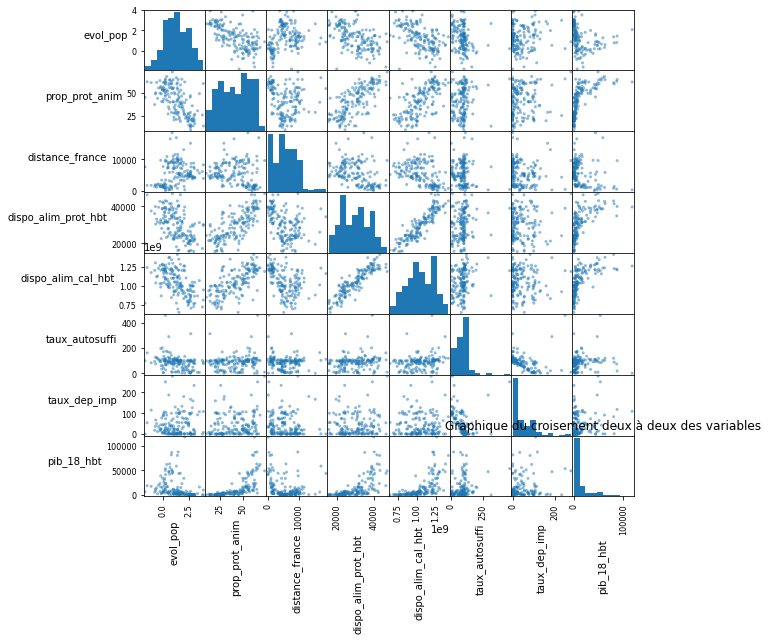

In [ ]:
#graphique : croisement deux à deux des variables
axes = pd.plotting.scatter_matrix(infos_pays_quant,figsize=(9,9))

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    
plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.title('Graphique du croisement deux à deux des variables')
plt.show()

## I- Classification Ascendante hiérarchique

In [ ]:
# préparation des données pour le clustering
X = infos_pays_quant.values 
names = infos_pays_quant.index.get_level_values('Pays')
feature = infos_pays_quant.index.get_level_values('Code ISO3')
region =infos_pays_quant.index.get_level_values('Région')

### - Normalisons nos données

In [ ]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [ ]:
# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

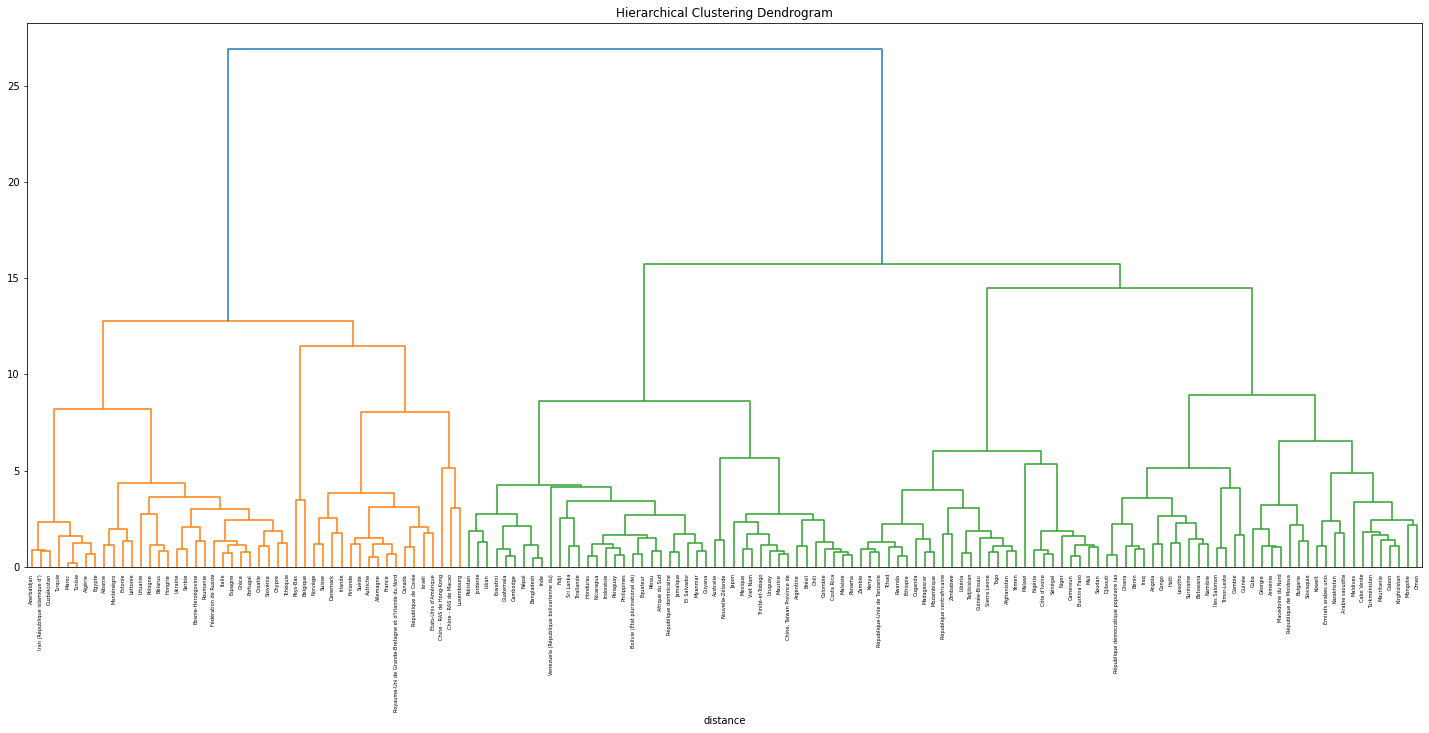

In [ ]:
# Affichage du dendrogramme
plot_dendrogram(Z, names, 'dataset_p5/new_data/image/Dendrogramme5.png')

### - Coupons notre dendrogramme

In [ ]:
# coupons notre dendrogramme de façon à obtenir 5 groupes et Récupérons nos clusters
k = 5
cluster = fcluster(Z, 5, criterion='maxclust')

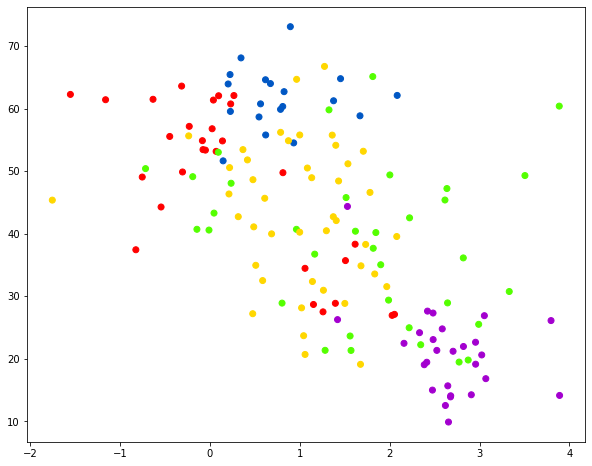

In [ ]:
#visualisons nos clusters
plt . figure ( figsize = ( 10 ,  8 )) 
plt . scatter ( X [:, 0 ],  X [:, 1 ],  c = cluster ,  cmap = 'prism' )   # tracer des points avec des couleurs dépendantes du cluster 
plt . show ()

In [ ]:
#consignons nos clusters dans un dataframe
group_pays = pd.DataFrame({"cluster":cluster,"Pays": names,"Code ISO3": feature,"Région":region})
group_pays.sample()

,cluster,Pays,Code ISO3,Région
113,1,Fédération de Russie,RUS,Europe


In [ ]:
# Nombre de pays pour chaque cluster
group_pays.cluster.value_counts()

3    43
5    35
1    29
4    27
2    19
Name: cluster, dtype: int64

### - regardons en détail chaque cluster

In [ ]:
# premier groupe de pays
group_pays[group_pays.cluster== 1].sample()

,cluster,Pays,Code ISO3,Région
88,1,Maroc,MAR,Afrique


In [ ]:
 # deuxième groupe de pays
group_pays[group_pays.cluster== 2].sample()

,cluster,Pays,Code ISO3,Région
137,2,Royaume-Uni de Grande-Bretagne et d'Irlande du...,GBR,Europe


In [ ]:
 # troisième groupe de pays
group_pays[group_pays.cluster== 3].sample()

,cluster,Pays,Code ISO3,Région
51,3,Honduras,HND,Amerique


In [ ]:
 # quatrième groupe de pays
group_pays[group_pays.cluster== 4].sample()

,cluster,Pays,Code ISO3,Région
18,4,République centrafricaine,CAF,Afrique


In [ ]:
 # cinquième groupe de pays
group_pays[group_pays.cluster== 5].sample()

,cluster,Pays,Code ISO3,Région
82,5,Maldives,MDV,Asie


#### - ajoutons les autres informations  nos clusters

In [ ]:
# joignons les informations du clustering à celles des pays
parametre_pays = pd.merge(group_pays,infos_pays_quant,on='Pays',how='outer')
parametre_pays.sample()

,cluster,Pays,Code ISO3,Région,evol_pop,prop_prot_anim,distance_france,dispo_alim_prot_hbt,dispo_alim_cal_hbt,taux_autosuffi,taux_dep_imp,pib_18_hbt
41,5,Gabon,GAB,Afrique,2.637127,47.208891,5413.107943,28900.7,961045000.0,4.878049,97.560976,8018.81644


In [ ]:
# Exportons notre table de cluster complétée .
parametre_pays.to_csv('dataset_p5/new_data/data_cluster.csv',index=False)


### - Description des clusters  en focnction des variables

Text(0.5, 1.0, 'Distribution du PIB en fonction des clusters ')

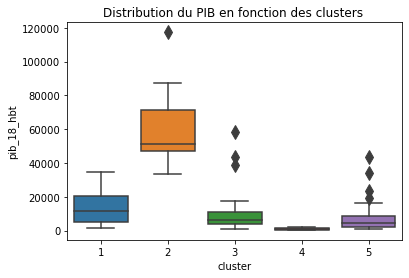

In [ ]:
# distribution du PIB suivant les clusters
sb.boxplot(x=parametre_pays['cluster'], y = parametre_pays['pib_18_hbt'],fliersize =10)
plt.title("Distribution du PIB en fonction des clusters ")

 **Note**
 * Les clusters 4 et 5 regroupes des pays sous developpés qui on un PIB très faible ce sont surtout les pays d'Afrique
 * Les clusters 2 et 1 quand à eux regroupent des pays riches avec un fort pouvoir d'achat par habitant il s'agit des pays d'Europe et d'Amérique et certains d'Asie .
 * Le cluster 3 quand  lui comprend des pays en pleine croissance et émergants ils sont intermédiaire.

Text(0.5, 1.0, 'evolution de la population d 2017-2018 ')

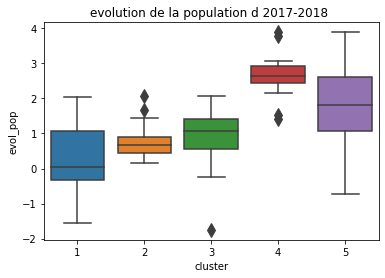

In [ ]:
# Evolution de la population suivant les clusters
sb.boxplot(x=parametre_pays['cluster'], y = parametre_pays['evol_pop'],fliersize =10)
plt.title("evolution de la population d 2017-2018 ")

**Note**
* Les clusters 1 et 3 regroupent les pays qui ont les évolutions de population les plus faible. 
* Les clusters 4 et 5 sont ceux où la population augmente beaucoup 
* le cluster 2  comprend 50% de pays dont la population est plutôt décroissante

Text(0.5, 1.0, "Taux d'autosuffisance (%) ")

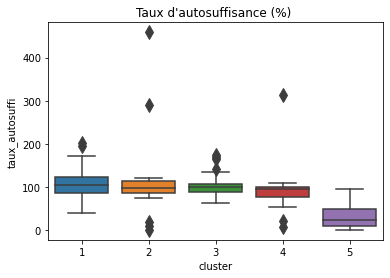

In [ ]:
# Distribution du taux d'autosuffisance suivant les clusters
sb.boxplot(x=parametre_pays['cluster'], y = parametre_pays['taux_autosuffi'],fliersize =10)
plt.title("Taux d'autosuffisance (%) ")

**Note**
Sans surprise les pays du cluster 5 on une autosuffisance très faible certainement du au nombre d'habitant qui augmente fortement.


Text(0.5, 1.0, 'Taux de dépendance aux importations (%) ')

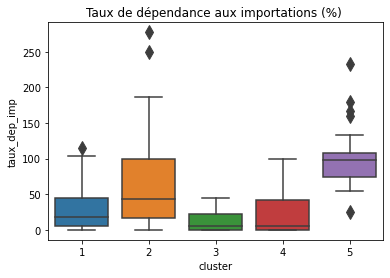

In [ ]:
# distribution du taux de dépendance aux importations suivant les clusters
sb.boxplot(x=parametre_pays['cluster'], y = parametre_pays['taux_dep_imp'],fliersize =10)
plt.title("Taux de dépendance aux importations (%) ")

** Note**
* le cluster 2 regroupe les pays qui dépendent le plus des importations suivi du cluster 5.
* Dans les clusters 4, 3 et 1 on consomme moins du poulet importé. 


Text(0.5, 1.0, 'proportion de proteine animale (%) ')

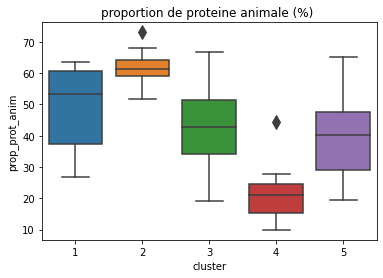

In [ ]:
# Distribution de la proportion de proteine animale suivant les clusters
sb.boxplot(x=parametre_pays['cluster'], y = parametre_pays['prop_prot_anim'],fliersize =10)
plt.title("proportion de proteine animale (%) ")

**Note**
* les pays les plus pauvres (regroupés dans les cluster 4) ont une faible alimentation en protéine animale. Par ailleur le cluster 2 comprend les pays qui consomment le plus de viande

Text(0.5, 1.0, 'Disponibité alimentaire en calorie par habitant ')

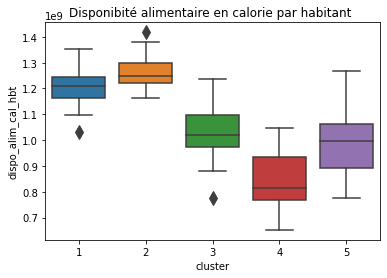

In [ ]:
# Distribution de la disponibilité alimentaire en calorie par habitant suivant les clusters
sb.boxplot(x=parametre_pays['cluster'], y = parametre_pays['dispo_alim_cal_hbt'],fliersize =10)
plt.title("Disponibité alimentaire en calorie par habitant ")

Text(0.5, 1.0, 'Disponibité alimentaire en proteine par habitant ')

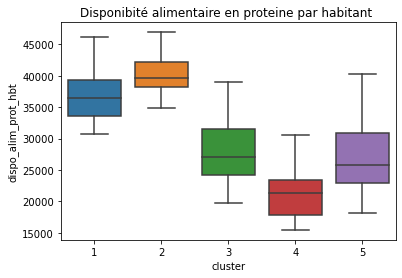

In [ ]:
# Distribution de la disponibilité  alimentaire en protéine par habitant suivant les clusters
sb.boxplot(x=parametre_pays['cluster'], y = parametre_pays['dispo_alim_prot_hbt'],fliersize =10)
plt.title("Disponibité alimentaire en proteine par habitant ")

**Note**
* les disponibilités alimentaires sont distribuées de la même manière elles suivent les même tendances que le PIB ainsi les pays les plus riches (clusters 1 et 2) ont un accès facile à la nourriture. Les pays pauvres ont un moindre accès  celles-ci.

  ### - Calculons le Coefficient de corrélation cophénétique
  
   Ce coefficient nous permet de comparer les distances réeles par paires de tous nos échantillons à celles impliquées dans le regroupement hiérarchique.
Plus sa valeur est proche de 1, mieux le clustering préserve les distances d'origine

In [ ]:
from scipy.cluster.hierarchy  import  cophenet 
from  scipy.spatial.distance  import  pdist

c ,  coph_dists  =  cophenet ( Z ,  pdist ( X )) 
print("Le coefficient de corrélation cophénétique est égale  {} ce qui veut dire que le le clustering tant à préserver les distances d'origine.".format(round(c , 2)))

Le coefficient de corrélation cophénétique est égale  0.46 ce qui veut dire que le le clustering tant à préserver les distances d'origine.


In [ ]:
# vérifions si les pays regrouper en clutser sont de la même région

# Comparaison des clusters trouvés avec les classification des pays en différentes région
pays = pd.DataFrame({"Région": Region, "cluster": cluster, "Tableau de contingence": names})
print(pays)
print(pays.pivot_table(index="Région", columns="cluster", aggfunc=len, fill_value=0))


      Région  cluster Tableau de contingence
0       Asie        5                Arménie
1       Asie        4            Afghanistan
2     Europe        1                Albanie
3    Afrique        1                Algérie
4    Afrique        5                 Angola
..       ...      ...                    ...
148   Europe        2               Belgique
149   Europe        2             Luxembourg
150   Europe        1                 Serbie
151   Europe        1             Monténégro
152  Afrique        4                 Soudan

[153 rows x 3 columns]
         Tableau de contingence                
cluster                       1   2   3   4   5
Région                                         
Afrique                       4   0   3  24  13
Amerique                      0   2  21   0   3
Asie                          5   4  16   3  14
Europe                       20  13   0   0   4
Oceanie                       0   0   3   0   1


### observation du taleau de contingence
* A peu près tous les continents sont représentés dans nos clusters mais à des proportions différentes 
* le cluster 4 est constitué presque exclusivement des pays d'Afrique 
* le cluster 5 regroupes essentiellement les pays d'Afrique et d'Asie mais aussi quelques uns d'Amérique et d'Europe
* Les cluster 1 et 2  quand à eux  comprennent surtout des pays d'Europe et d'Asie
* le cluster 3 a absorbé la majorité des pays d'Amérique mais aussi plusieurs pays d'Asie et les pays d'Océanie avec une poignées de pays d'Afrique

**Remarque: L'Océanie,et l'Amérique ne sont pas assez représenté dans notre échantillon au lieu de 14 et 50, nous avons plutôt 5 et 27 pays**

### - CALCUL DES CENTROÏDES

In [ ]:
# créons un dataframe vide pour y stoquer les données des centroides
centroides = pd.DataFrame()


In [ ]:
noms_clusters = parametre_pays['cluster'].unique()
noms_clusters

array([5, 4, 1, 3, 2], dtype=int32)

522.3729998275184

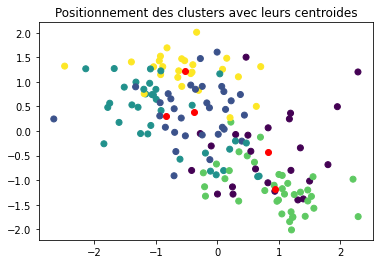

In [ ]:

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Nombre de clusters souhaités
n_clust = 5
# Nous ne réduisont plus car on l'a deja fait plus haut
X = X_scaled
# nous consitérerons les variable utiliser par le CAH

model= KMeans(n_clusters =n_clust)
model.fit(X) # entrainon notre jeux de donnée
model.predict(X) # pour voir comment sont affiché nos donnes
plt.scatter(X[:,0], X[:,1],c = model.predict(X))
plt.scatter(model.cluster_centers_[:,0],model.cluster_centers_[:,1],c='r')
plt.title("Positionnement des clusters avec leurs centroides")
model.inertia_ # pour trouver la somme des distances entre les points d'un cluster et le centroide son unité dépend de celle des variables utilisées

In [ ]:
# coordonnées des centroids
cordo_centroides = model.cluster_centers_
cordo_centroides # on a 8 colonnes car nous travaillons sur 8 dimensions

array([[ 0.82951187, -0.42604122,  0.26779882, -0.63025713, -0.65686033,
        -1.01963162,  1.29023825, -0.502788  ],
       [-0.37925726,  0.39458078,  1.2255358 , -0.04635632,  0.02930114,
         0.31493279, -0.63348652, -0.12898641],
       [-0.83210161,  0.29606185, -0.84038138,  0.54377881,  0.6770868 ,
         0.07639046, -0.1398197 , -0.16932254],
       [ 0.93666953, -1.1694475 ,  0.14825144, -1.01462713, -1.07999512,
         0.08547167, -0.50205732, -0.63547133],
       [-0.53221075,  1.22023187, -0.8686509 ,  1.40474076,  1.24355171,
         0.34228767,  0.51102645,  1.82532821]])

### - Exportons les coordonnées des centroides

In [ ]:

# créons un dataframe qui contiendra ces données

row_indices = ["cluster1", "cluster2", "cluster3", "cluster4","cluster5"]
column_names = ["dim1", "dim2", "dim3","dim4","dim5","dim6","dim7","dim8"]
cordo_centroides = pd.DataFrame(cordo_centroides, index = row_indices , columns =column_names )
cordo_centroides

cordo_centroides.to_csv('dataset_p5/new_data/cordo_centroides.csv') # exportons les coordonnées de nos centroides dans un csv

In [ ]:
cordo_centroides

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8
cluster1,0.829512,-0.426041,0.267799,-0.630257,-0.656860,-1.019632,1.290238,-0.502788
cluster2,-0.379257,0.394581,1.225536,-0.046356,0.029301,0.314933,-0.633487,-0.128986
cluster3,-0.832102,0.296062,-0.840381,0.543779,0.677087,0.076390,-0.139820,-0.169323
cluster4,0.936670,-1.169447,0.148251,-1.014627,-1.079995,0.085472,-0.502057,-0.635471
cluster5,-0.532211,1.220232,-0.868651,1.404741,1.243552,0.342288,0.511026,1.825328


In [ ]:
# trouvons le nombre de cluster optimal avec la méthode de coude
inertia = [] #créons une liste qu'on nomme inertia
K_range = range(1, 20 ) # crons une rangé de valeur
for k in K_range: 
    model = KMeans(n_clusters=k).fit(X) # on crée un model et qu'on entraine 
    inertia.append(model.inertia_) # on calcul le cout qu'on va rentrer dans notre liste


C:\Users\mefoo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0, 0.5, 'Coût du modele (Inertia)')

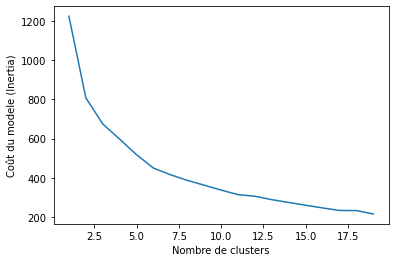

In [ ]:
#Tracons la courbe et identifions la zone du coude
plt.plot(K_range,inertia)
plt.xlabel('Nombre de clusters')
plt.ylabel('Coût du modele (Inertia)')

### > Identification du nombre de cluster optimal
* Nous identifions ici une petite zone de coude pour un nombre de cluster égale à 6

# choix du cluster
Le choix du cluster cible se portera sur celui ayant un taux de dépendance aux importations élevés et un fort pouvoir d'achat.
Les clusters succeptibles de nous intéresser dans notre étude de marché sont **les clusters 2 et 1 éventuellement** car se sont ceux la qui ont un fort pouvoir d'achat et disposent des ressouces necessaire pour s'approvisionner en volaille de plus ces derniers ont une forte alimentation carnée 


# Analyse en Composantes Principales
L'acp nous aidera à:
* Réduire le nombre de variables étudiées par la détermination des liaisons entres celles-ci et si besoin est, de déterminer les variables synthétiques.
* Comprendre les variations entre les individus.

#### Après avoir sélectionner les variables actives
* nous utiliserons les données centrées réduites afin d'accorder la même importance à toutes les variables

* CHOIX DU NOMBRE DE COMPOSANTE

In [ ]:
# Mettons les variables illustratives en index
parametre_pays.set_index(['cluster','Code ISO3','Pays','Région'], inplace = True)

In [ ]:
# choix du nombre de composant à calculer  par defaut , ce nombre est souvent égale au nombre de variable
n_comp = 6 # nous allons limiter ce nombre à 6

In [ ]:
# Identifions nos paramètres
X = parametre_pays.values
names = parametre_pays.index.get_level_values('Code ISO3') # ou infos_pays.index pour avoir les intitulés
features = parametre_pays.columns
cluster = parametre_pays.index.get_level_values('cluster') 

In [ ]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

In [ ]:
pca

PCA(n_components=6)

In [ ]:
X_scaled

array([[-0.91467304,  0.41746835, -0.60306976, ..., -1.06623956,
         0.54564795, -0.49948663],
       [ 0.99551056, -1.40367301, -0.01424145, ..., -0.57044614,
         0.04819017, -0.67898389],
       [-1.16537256,  0.75453238, -1.10462586, ..., -0.4901607 ,
        -0.00362835, -0.44982358],
       ...,
       [-1.38897716,  0.53217073, -1.14680888, ...,  0.10981551,
        -0.53485524, -0.3556436 ],
       [-1.08749685,  1.26375029, -1.13461959, ..., -0.83057094,
         0.86253813, -0.28086573],
       [ 1.00266616, -0.88344043, -0.28549005, ...,  0.30908031,
        -0.84866881, -0.64665058]])

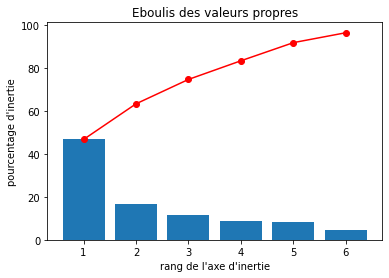

In [ ]:
# Eboulis des valeurs propres
display_scree_plot(pca)

### Quelle est la variance expliquée par chacune des deux composantes?

In [ ]:
# Attribut du modèle PCA pour retrouver la quantité de variance expliquée par chaque composante
valeur_propre=pca.explained_variance_

In [ ]:
# Attribut du modèle PCA pour retrouver le pourcentage  de variance expliquée par chaque composante
pca.explained_variance_ratio_

array([0.46676026, 0.16583102, 0.11353163, 0.08682131, 0.08437306,
       0.04608098])

* La composante 1 explique 46,67 % de l'information et la composante 2 explique 16,58 % de l'information. Les autres composantes n'explique très peu d'information .
**NOTE ** : Ces observations  peuvent nous permettre de comprendre la dimension de notre jeu de données nous pouvons de ce fait passer de 9 variables à 2 variables uniquement pour notre analyse.

In [ ]:
# La variance du milieu :Afin de voir le pourcentage de variance qu'on peut expliquer en utilisant un certain nombre de composant
pca.explained_variance_ratio_.cumsum()

array([0.46676026, 0.63259128, 0.7461229 , 0.83294421, 0.91731727,
       0.96339825])

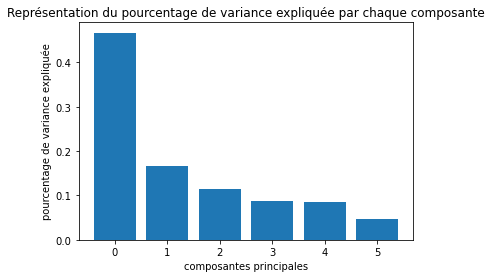

In [ ]:
# visualisation du pourcentage de variance expliquée par chaque composante
plt.bar(range(pca.n_components_),pca.explained_variance_ratio_)
plt.xlabel('composantes principales')
plt.ylabel('pourcentage de variance expliquée')
plt.xticks(range(pca.n_components_))
plt.title('Représentation du pourcentage de variance expliquée par chaque composante' )
plt.show()

### - Cercle de corrélation

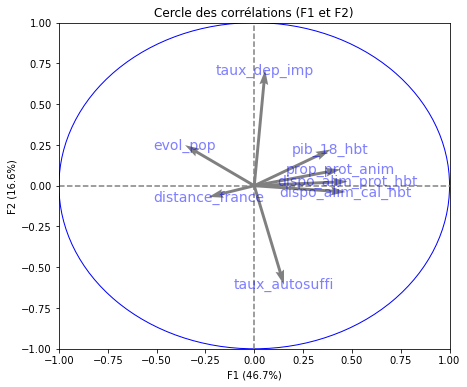

In [ ]:
#affichons le Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

In [ ]:
# Retrouvons les coordonnées des composants principaux au niveau de chaque axe
pcs = pca.components_
pcs

array([[-0.35432602,  0.44135223, -0.23317264,  0.47719778,  0.46749805,
         0.15229887,  0.05594526,  0.39076185],
       [ 0.24885842,  0.09988919, -0.06869366,  0.02574167, -0.0387091 ,
        -0.60727976,  0.70937208,  0.22184302],
       [-0.10713558,  0.34085762,  0.90363448,  0.01516389, -0.03730707,
        -0.14495654, -0.09764474,  0.15366888],
       [ 0.14940513,  0.03170359,  0.15642027, -0.13296113, -0.15099144,
         0.76000963,  0.55535506,  0.16029577],
       [ 0.74068824, -0.1606448 ,  0.04002437,  0.16328918,  0.16964778,
         0.05661139, -0.33821055,  0.50093639],
       [-0.20904557,  0.23933203, -0.25923843, -0.43158378, -0.51132712,
        -0.05176813, -0.22222957,  0.57622016]])

### - Matrice de corrélation entre les variables

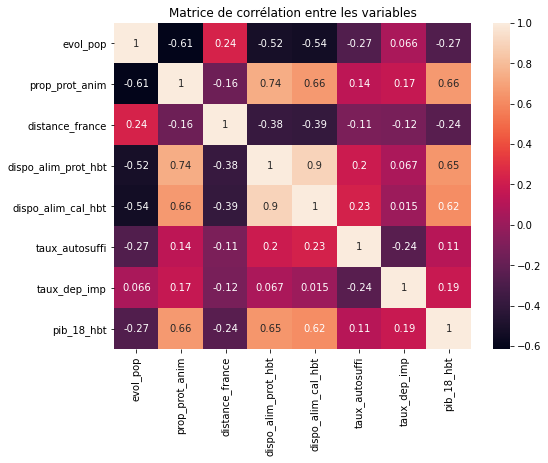

In [ ]:
# Matrice de corrélation 
corr_df = parametre_pays.corr(method='pearson')
plt.figure(figsize=(8, 6))
sb.heatmap(corr_df, annot=True)
plt.title('Matrice de corrélation entre les variables')
plt.show()


### Interprétons le cercle des corrélations

* Sur la composante F1: Les variables prop_ prot_anim, Dispo_alim_general, PIB_18_hbt, Dispo_proteine_general, dispo_alim_prot,dispo_alim_cal sont correlées positivement à l'axe F1 et l'évol_pop est corrélées négativement à F1 (**Je peux donc décider de garder 1 seule des variables correlées entre elle et positivement à F1**)
* Plus un pays aura une croissance démographique forte et plus sa valeur sur l’axe F1 sera négative

* Sur la composante F2:Le taux de dépendance aux importations et taux d'autosuffisance y sont fortement correlées négativement. Ainsi les pays dont le taux de dépendance aux importations élevé auronts un taux-autosuffisance faible et auront des valeurs positives sur l'axe F2

**Note** 
ce qui différencie les pays de notre échantillon c'est:
* La disponibité alimenantaire nous avons des pays qui disposent d'une quantité de nourriture suffisante suivant que la population augmente beaucoup  ou pas
* le type de cosommation (local ou importé)

### - Nuage des individus (Projettons nos individus sur le premier plan factoriel)

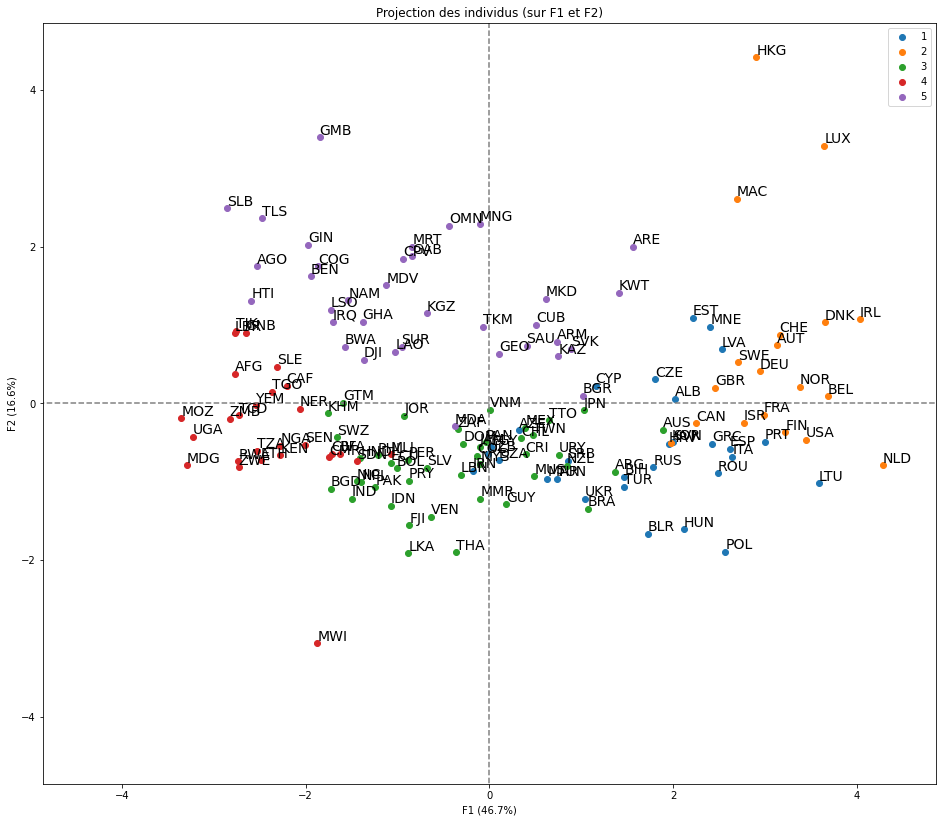

In [ ]:
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], labels = np.array(names),illustrative_var=cluster)

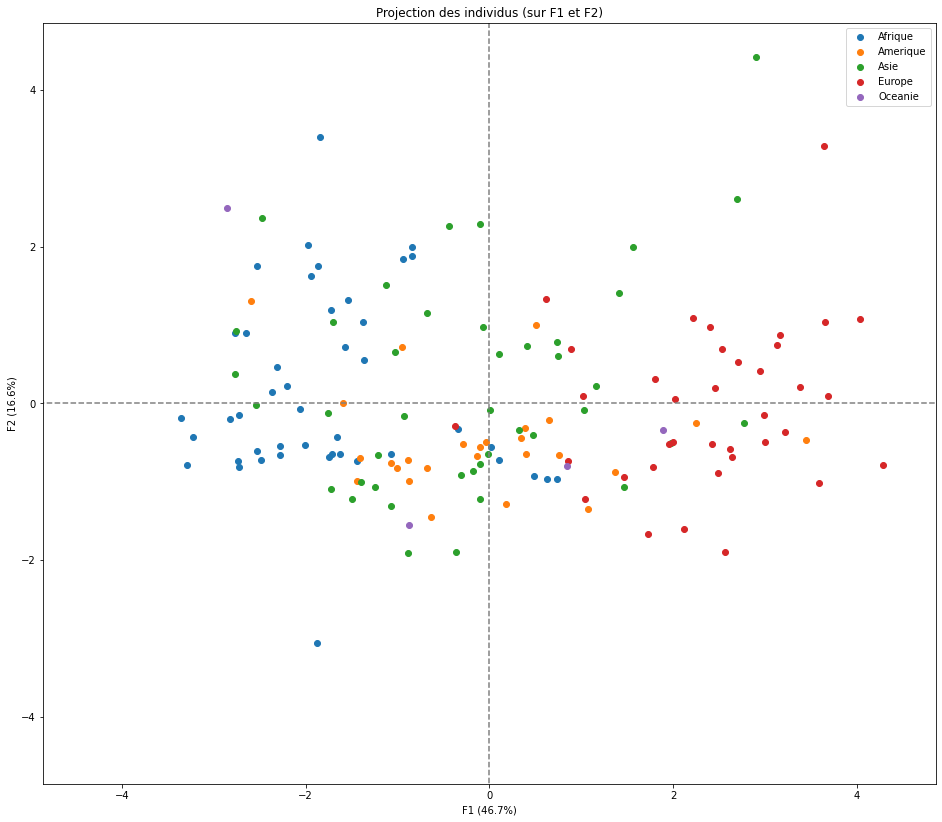

In [ ]:
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)],illustrative_var=region)


### - Calcul des contributions des individus dans  l'inertie totale

In [ ]:
di = np.sum(X_scaled**2,axis=1) 
print(pd.DataFrame({'ID':parametre_pays.index.get_level_values('Pays'),'d_i':di}))

              ID        d_i
0        Arménie   3.498327
1    Afghanistan   8.640709
2        Albanie   7.378546
3        Algérie   4.852130
4         Angola   9.920777
..           ...        ...
148     Belgique  30.927707
149   Luxembourg  35.890448
150       Serbie   3.981614
151   Monténégro   9.898206
152       Soudan   3.702918

[153 rows x 2 columns]


## Nouvelle population : Affinons la sélection des pays

Nous définissons un**nouveau seuil de viabilitité :** Nous ne considèrerons que les pays qui ont un nombre d'habitant suprieur ou égale **à 5 millions d'habitant**.

In [ ]:
infos_pays_quant.sample()

,,,evol_pop,prop_prot_anim,distance_france,dispo_alim_prot_hbt,dispo_alim_cal_hbt,taux_autosuffi,taux_dep_imp,pib_18_hbt
Pays,Région,Code ISO3,,,,,,,,
Lettonie,Europe,LVA,-1.16027,61.409657,1707.614663,37492.8,1.178585e+09,82.926829,114.634146,17846.380379


### - Sélectionons uniquement les pays > 5000000 hbts

In [ ]:
# prennons uniquement les pays dont la population est supérieur à 5millions d'habitant
infos_pays.reset_index(inplace = True)
pop_2 = infos_pays[infos_pays['pop_18'] >= 5000000 ]
parametre_pays.reset_index(inplace = True)
pays_reduit = pd.merge(pop_2[['pop_18','Pays']],parametre_pays,on = 'Pays', how = 'left')
#pays_reduit.set_index([])              
# les variables prop_prot_anim,dispo_alim_prot_hbt,dispo_alim_cal_hbt,pib_18_hbt étant correlées je ne retiendrais que prop_prot_anim et pib_18_hbt pour affiner mon traitement 
#pop_2=pop_2[['evol_pop','prop_prot_anim','taux_autosuffi','taux_dep_imp','pib_18_hbt']]

In [ ]:
# liste de pays avec le nombre d'habitant < 5000000 
pays_pop_inf= infos_pays[infos_pays['pop_18'] <= 5000000 ]
pays_pop_inf.sample()

,Pays,Région,Code ISO3,pop_18,evol_pop,distance_france,Dispo_alim_general,Dispo_protéines_general,prop_prot_anim,dispo_alim_prot_hbt,dispo_alim_cal_hbt,taux_autosuffi,taux_dep_imp,pib_18_hbt,cout_prod_anuel_poulet
0,Arménie,Asie,ARM,2951745.0,0.236146,3439.396932,2997.0,94.35,48.055114,34437.75,1.093905e+09,26.666667,73.333333,4220.534194,819.5


In [ ]:
# Proportion des pays dont le nombre d'habitant < 5 millions 

prop_pays_inf=(pays_pop_inf.shape[0]/infos_pays.shape[0])*100
print ("les pays  dont la population <5000000 représentent {} % de notre échantillons de pays.".format(round(prop_pays_inf, 2)))

les pays  dont la population <5000000 représentent 28.76 % de notre échantillons de pays.


In [ ]:
pays_reduit.sample()

,pop_18,Pays,cluster,Code ISO3,Région,evol_pop,prop_prot_anim,distance_france,dispo_alim_prot_hbt,dispo_alim_cal_hbt,taux_autosuffi,taux_dep_imp,pib_18_hbt
82,57792518.0,Afrique du Sud,3,ZAF,Afrique,1.373032,42.704753,9306.63853,30795.05,1.058135e+09,79.084381,23.114901,6369.231608


In [ ]:
pays_reduit.set_index(['Pays','Région','Code ISO3','cluster'], inplace = True)
pays_reduit= pays_reduit[['evol_pop','prop_prot_anim','taux_autosuffi','taux_dep_imp','pib_18_hbt']]

In [ ]:
pays_reduit.shape

(109, 5)

In [ ]:
# préparation des données pour l'ACP
pays_reduit = pays_reduit.fillna(pop_2.mean())

In [ ]:
clean_dataset(pays_reduit)

,,,,evol_pop,prop_prot_anim,taux_autosuffi,taux_dep_imp,pib_18_hbt
Pays,Région,Code ISO3,cluster,,,,,
Afghanistan,Asie,AFG,4,2.412953,19.434438,54.716981,47.169811,483.885875
Algérie,Afrique,DZA,1,2.027629,26.930197,100.000000,0.000000,4153.957220
Angola,Afrique,AGO,5,3.330411,30.744581,7.458564,92.541436,3289.643374
Argentine,Amerique,ARG,3,0.965038,64.671724,107.743250,0.662252,11719.075678
Australie,Oceanie,AUS,3,1.275318,66.735888,101.981833,1.321222,58596.826341
...,...,...,...,...,...,...,...,...
Yémen,Asie,YEM,4,2.385013,19.038885,97.297297,51.891892,803.648363
Zambie,Afrique,ZMB,4,2.955505,22.633405,84.482759,18.965517,1556.338275
Belgique,Europe,BEL,2,0.546685,58.656253,290.123457,187.037037,47354.636623


In [ ]:
pays_reduit =pays_reduit[~pays_reduit.isin([np.nan, np.inf, -np.inf]).any(1)]

In [ ]:
n_comp = 4

In [ ]:
X = pays_reduit.values
names = pays_reduit.index.get_level_values('Code ISO3') # ou infos_pays.index pour avoir les intitulés
features = pays_reduit.columns
region = pays_reduit.index.get_level_values('Région')
clusters = pays_reduit.index.get_level_values('cluster')

In [ ]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [ ]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=4)

In [ ]:
# Attribut du modèle PCA pour retrouver le pourcentage  de variance expliquée par chaque composante
pca.explained_variance_ratio_

array([0.48750912, 0.20950572, 0.16769748, 0.10233131])

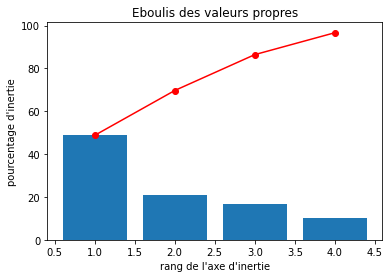

In [ ]:
# Eboulis des valeurs propres
display_scree_plot(pca)

- Les deux premières composantes expliquent 70 % de l'information contenu dans nos données

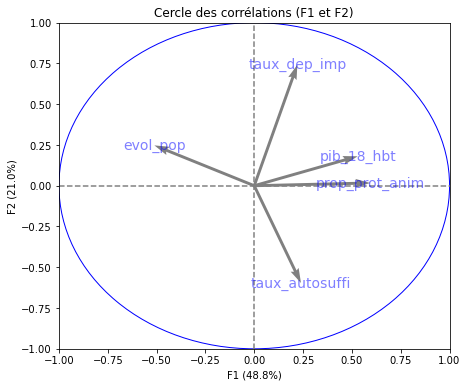

In [ ]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

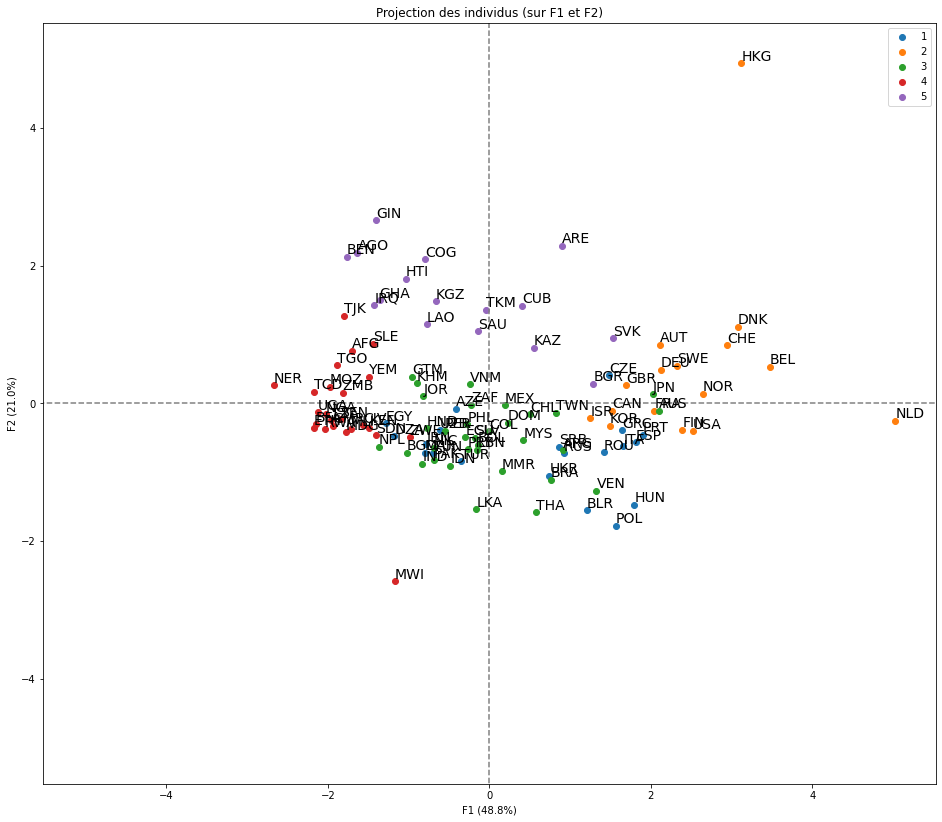

In [ ]:
# Projection des individus sur les différents plans

X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], labels = np.array(names),illustrative_var=clusters)

**Nous pouvons retenir au vue de ce nuage de point les pays situés dans la partie supérieure droite pour notre étude de marché. Pour affiner cette liste il conviendra de regarder les données brut pour tirer des conclusions**

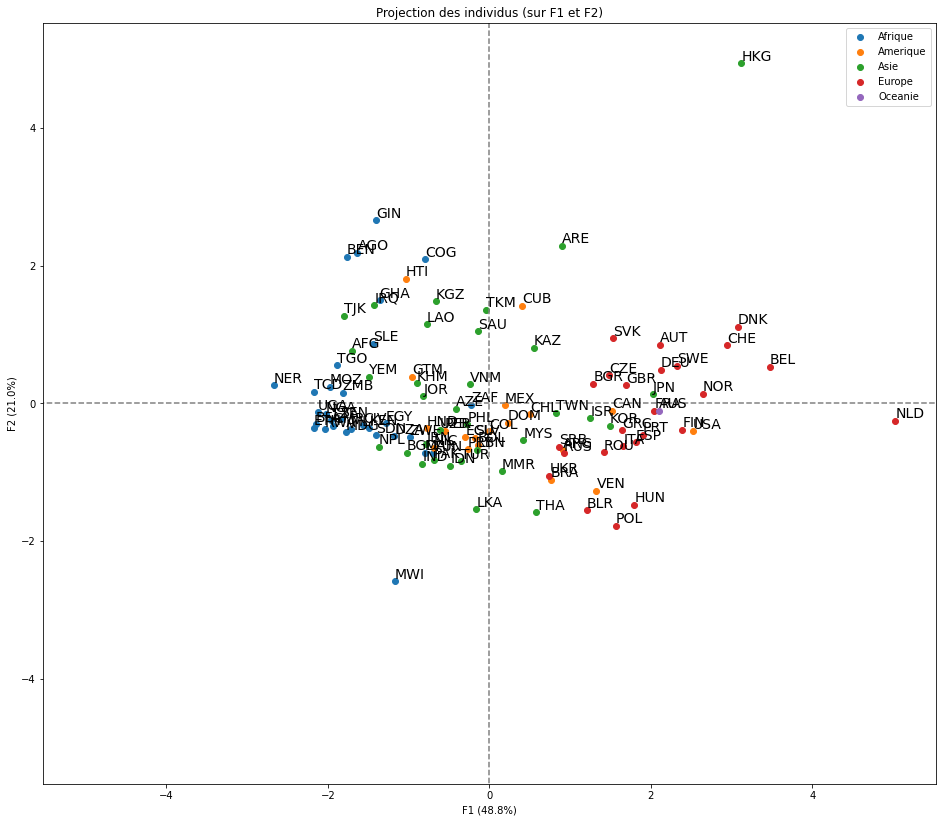

In [ ]:
# Projection des individus sur les différents plans 

X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], labels = np.array(names),illustrative_var=region)

# II- Test statistique

<br/>

## - Test d'adéquation à la loi normale

In [ ]:
#test d'adéquation à la loi normale sur la variable de proportion de proteine animale
# définition notre échatillon test
echantillon = infos_pays_quant['prop_prot_anim']
import numpy, math
xbar=numpy.mean(echantillon)
round(xbar,2)

41.49

In [ ]:
sprime = np.std(echantillon, ddof=1)
round(sprime,2)

15.77

In [ ]:
x_min= echantillon.min()

In [ ]:
x_max= echantillon.max()

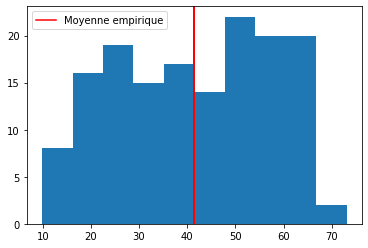

In [ ]:


# Affichons l'histogramme qui représente la distribution de la proportion de protéine animale

import scipy.stats as st # superposons à cette distribution la densité gaussienne
plt.hist(echantillon, bins=10)
plt.axvline(xbar, color='r', linewidth=2)
import matplotlib.lines as mlines
plt.legend(handles=[mlines.Line2D([], [], color='red',markersize=15, label="Moyenne empirique")])



Text(0.5, 1.0, 'Histogramme et densité normale')

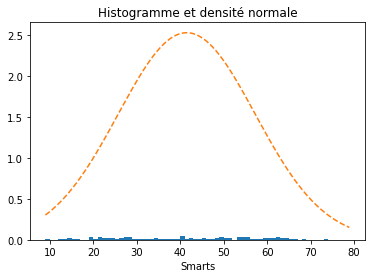

In [ ]:
from scipy.stats import norm
import matplotlib.mlab as mlab
fig, ax = plt.subplots()
n, bins, patches = ax.hist(echantillon,density = 1,bins=range(9,80))
bins=numpy.arange(9,79,0.1)
y = norm.pdf(bins, xbar,sprime)*100
ax.plot(bins, y, '--')
ax.set_xlabel('Smarts')
ax.set_title("Histogramme et densité normale")

### - Critères pour un test de kolmogorov_smirnov
- variable continue
Hypothèse test
* Hypothèse nulle (H0): l’échantillon suit une loi normale
* Hypothèse alternative (H1): l’échantillon ne suit pas une loi normale

* Nous ferons donc le test de Kolmogorov-Smirnoc car n > 60

In [ ]:
from scipy.stats import ks_2samp

In [ ]:
ks_2samp(echantillon,list(numpy.random.normal(numpy.mean(echantillon), numpy.std(echantillon), 1000)))

#stats.kstest(echantillon, 'norm', alternative='greater')
#kstest(echantillon,"norm",echantillon.mean(),echantillon.std())

KstestResult(statistic=0.08669281045751634, pvalue=0.25468083872717695)

* On ne pas pas rejetter l'hypothèse nulle 
* Nous constatons bien que la p-value (0,25) est supérieur au niveau de test de 5% 
* Notre variable Proportion de protéine animale est distribué suivant une loi normale.

## - Test de comparaison de deux populations.
Comparons les Groupes  de pays 3 et 5

In [ ]:
parametre_pays.sample()

,cluster,Code ISO3,Pays,Région,evol_pop,prop_prot_anim,distance_france,dispo_alim_prot_hbt,dispo_alim_cal_hbt,taux_autosuffi,taux_dep_imp,pib_18_hbt
30,3,DOM,République dominicaine,Amerique,1.084713,50.490122,7195.94557,24203.15,1.055580e+09,87.25,14.25,8050.649783


testons d'abord l'égalité des variances :

In [ ]:
subset= parametre_pays[['prop_prot_anim','cluster']]
echantillon1 = subset[subset['cluster']== 3]['prop_prot_anim']
echantillon2 = subset[subset['cluster']== 5]['prop_prot_anim']

In [ ]:
 # égalité des variances

scipy.stats.bartlett(echantillon1,echantillon2)
#var.test(echantillon1, echantillon2)

BartlettResult(statistic=0.2218126989238819, pvalue=0.6376621903159416)

* La p-valeur vallant 0,63,l'hypothèse de l'égalité des variances est approuvée  au niveau de test de 5%.
* Nous pouvons donc considérer que les variances sont égale pour nos echatillons.

testons ensuite l'égalité des moyennes :

In [ ]:
scipy.stats.ttest_ind(echantillon1,echantillon2, equal_var=True)

Ttest_indResult(statistic=1.6207385634730984, pvalue=0.10921575348999003)

* l'hypothèse nulle vérifiant l'égalité des moyennes ne peut pas être rejettée au vue de la p-valeur = 0,10

In [ ]:
parametre_cluster= subset[(subset['cluster']==3) | (subset['cluster']== 5)]

In [ ]:
parametre_cluster['cluster'].unique()

array([5, 3], dtype=int64)

Text(0.5, 1.0, 'Corélation entre la proportion de protéine animale et les clusters 3 et 5')

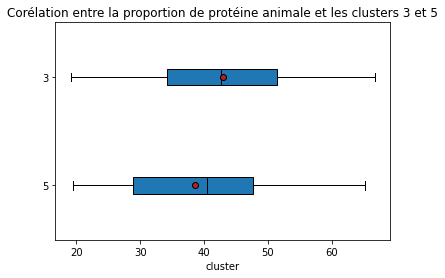

In [ ]:
modalites = parametre_cluster['cluster'].unique()
groupes = []
for m in modalites:
    groupes.append(parametre_cluster[parametre_cluster['cluster']==m]['prop_prot_anim'])

medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.boxplot(groupes, labels= modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel('cluster')
plt.title('Corélation entre la proportion de protéine animale et les clusters 3 et 5'  )


